# InceptionV3

# Overall Model Evaluation on HAM10000 Test Set and Fairness Evaluation for Sensitive Feature Skin Type

In [2]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import pandas as pd
import os
from skimage import io
import torch
from skimage import color
import pickle
import copy
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_negative_rate, false_positive_rate
import warnings

In [3]:
if torch.cuda.is_available:
    print('Running on GPU.')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found. Running on CPU.')
    device = torch.device('cpu')

Running on GPU.
Tesla V100-PCIE-32GB


## HAM10000 Test Set

In [4]:
def class_label(label):
    if label == 'akiec':
        label = 0
    elif label == 'bcc':
        label = 1
    elif label == 'bkl':
        label = 2
    elif label == 'df':
        label = 3
    elif label == 'mel':
        label = 4
    elif label == 'nv':
        label = 5
    elif label == 'vasc':
        label = 6
    return label

validation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299), 
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = load_data_and_get_class(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1]+'.jpg')
        
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]
            
        image_class = self.data_frame.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)

        sample = {'x': image, 'y': image_class}

        return sample

def load_data_and_get_class(path_to_data):
    data = pd.read_csv(path_to_data)
    data['Class'] = data['dx'].apply(class_label)
    return data

In [5]:
best_bs = 16

test_df_path = 'test.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/SkinCancer/Images'

HAM10000_dataset = {'test': HAM10000Dataset(test_df_path, root_image_directory, validation_transform)}
HAM10000_dataloader = {x: DataLoader(HAM10000_dataset[x], batch_size=best_bs, shuffle=False) for x in ['test']}

## HIBA Set

In [6]:
def class_label(label):
    if label == 'melanoma':
        label = 4
    elif label == 'seborrheic keratosis':
        label = 2
    elif label == 'nevus':
        label = 5
    elif label == 'actinic keratosis':
        label = 0
    elif label == 'basal cell carcinoma':
        label = 1
    elif label == 'solar lentigo':
        label = 2
    elif label == 'squamous cell carcinoma':
        label = 0
    elif label == 'dermatofibroma':
        label = 3
    elif label == 'vascular lesion':
        label = 6
    elif label == 'lichenoid keratosis':
        label = 2
    return label

validation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299), 
    transforms.CenterCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class HIBADataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = load_data_and_get_class(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1]+'.JPG')
        
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]

        image_class = self.data_frame.iloc[idx, -1]

        if self.transform:
            image = self.transform(image)

        sample = {'x': image, 'y': image_class}

        return sample

def load_data_and_get_class(path_to_data):
    data = pd.read_csv(path_to_data)
    data['Class'] = data['diagnosis'].apply(class_label)
    return data

In [7]:
best_bs = 16

test_df_path = 'HIBA_dataset_skin_type.csv'
root_image_directory = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HIBA/Images'

HIBA_dataset = {'test': HIBADataset(test_df_path, root_image_directory, validation_transform)}
HIBA_dataloader = {x: DataLoader(HIBA_dataset[x], batch_size=best_bs, shuffle=False) for x in ['test']}

## Evaluation Methods/Functions

In [8]:
def get_test_predictions(model_path, dataloader):
    """
    Returns true labels, predictions, and predicted labels
    """
    model = torch.load(model_path)
    model.eval()
    model_test_predictions = []
    model_test_labels = []
    for data in dataloader['test']:
        image = data['x'].to(device)
        label = data['y'].to(device)
        outputs = model(image)
        model_test_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        model_test_labels.extend(label.cpu().detach().numpy())
        
    model_test_predictions_labels = np.argmax(np.array(model_test_predictions), axis=1)
    
    return model_test_labels, model_test_predictions, model_test_predictions_labels

In [9]:
def macro_avg_auc(model_test_labels, model_test_predictions):
    model_test_auc_score = roc_auc_score(np.array(model_test_labels), np.array(model_test_predictions), multi_class='ovr', average='macro')
    per_class_auc = roc_auc_score(np.array(model_test_labels), np.array(model_test_predictions), multi_class='ovr', average=None)
    return model_test_auc_score, per_class_auc

def macro_avg_precision(model_test_labels, model_test_predictions_labels):
    macro_precision = precision_score(model_test_labels, model_test_predictions_labels, average='macro', zero_division=0)
    per_class_precision = precision_score(model_test_labels, model_test_predictions_labels, average=None, zero_division=0)
    return macro_precision, per_class_precision

def macro_avg_recall(model_test_labels, model_test_predictions_labels):
    macro_recall = recall_score(model_test_labels, model_test_predictions_labels, average='macro')
    per_class_recall = recall_score(model_test_labels, model_test_predictions_labels, average=None)
    return macro_recall, per_class_recall

def macro_avg_f1(model_test_labels, model_test_predictions_labels):
    macro_f1 = f1_score(model_test_labels, model_test_predictions_labels, average='macro')
    per_class_f1 = f1_score(model_test_labels, model_test_predictions_labels, average=None)
    return macro_f1, per_class_f1

def overall_accuracy(model_test_labels, model_test_predictions_labels):
    overall_accuracy = balanced_accuracy_score(model_test_labels, model_test_predictions_labels)
    per_class_accuracy = []

    for class_index in range(7):
        class_true = [1 if model_test_labels[i] == class_index else 0 for i in range(len(model_test_labels))]
        class_pred = [1 if model_test_predictions_labels[i] == class_index else 0 for i in range(len(model_test_predictions_labels))]
        per_class_accuracy.append(balanced_accuracy_score(class_true, class_pred))
        
    return overall_accuracy, per_class_accuracy

In [10]:
def get_overall_metrics(y_true, y_pred_prob, y_pred):
    macro_auc_score, per_class_auc = macro_avg_auc(y_true, y_pred_prob)

    precision, per_class_precision = macro_avg_precision(y_true, y_pred)

    recall, per_class_recall = macro_avg_recall(y_true, y_pred)

    f1, per_class_f1 = macro_avg_f1(y_true, y_pred)

    accuracy, per_class_accuracy = overall_accuracy(y_true, y_pred)
    
    per_class_metrics = pd.DataFrame({
        'Class': range(len(per_class_precision)),
        'Balanced Accuracy': per_class_accuracy,
        'Precision': per_class_precision,
        'Recall': per_class_recall,
        'F1': per_class_f1,
        'AUC': per_class_auc
    })

    overall_metrics = pd.DataFrame({
        'Metric': ['Balanced Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1', 'Macro Avg Ovr AUC'],
        'Value': [accuracy, precision, recall, f1, macro_auc_score]
    })

    print("\nPer Class Metrics:")
    print(per_class_metrics)

    print("\nOverall Metrics:")
    print(overall_metrics)

    return per_class_metrics, overall_metrics

In [11]:
def binary_class_label(label):
    if label in [0,1,4]:
        label = 1
    elif label in [2,3,5,6]:
        label = 0
    return label

def convert_to_binary(y_true, y_pred_prob, y_pred):
    y_true_binary = [binary_class_label(label) for label in y_true]
    y_pred_binary = [binary_class_label(label) for label in y_pred]
    
    positive_classes = [0, 1, 4]
    negative_classes = [2, 3, 5, 6]
    predicted_probabilities_binary = []
    
    for i in range(len(y_pred_prob)):
        sum_positive = np.sum(y_pred_prob[i][positive_classes])
        sum_negative = np.sum(y_pred_prob[i][negative_classes])
        predicted_probabilities_binary.append(np.array([sum_positive]))

    return y_true_binary, predicted_probabilities_binary, y_pred_binary

def binary_auc(model_test_labels, model_test_predictions):
    model_test_auc_score = roc_auc_score(np.array(model_test_labels), np.array(model_test_predictions))
    return model_test_auc_score

In [12]:
def get_metric_frame(y_true, y_pred_prob, y_pred, sensitive_feat):
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true", category=UserWarning)
    warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'.*")
    hiba_w_skin_type =  pd.read_csv('HIBA_dataset_skin_type.csv')
    sensitive_feature = hiba_w_skin_type[sensitive_feat].astype(str)
    
    metrics = {
        'Balanced Acc': skm.balanced_accuracy_score,
        'Precision': lambda y_true, y_pred: skm.precision_score(y_true, y_pred, zero_division=0),
        'Recall': lambda y_true, y_pred: skm.recall_score(y_true, y_pred, zero_division=0),
        'F1': lambda y_true, y_pred: skm.f1_score(y_true, y_pred, zero_division=0),
        'FNR': false_negative_rate,
        'FPR': false_positive_rate
    }
    y_true_binary, predicted_probabilities_binary, y_pred_binary = convert_to_binary(y_true, y_pred_prob, y_pred)
    auc_score = binary_auc(y_true_binary, predicted_probabilities_binary)
    print('AUC on HIBA Dataset:', auc_score)
    grouped_on_skintype = MetricFrame(metrics=metrics,
                             y_true=y_true_binary,
                             y_pred=y_pred_binary,
                             sensitive_features=sensitive_feature)
    return grouped_on_skintype

In [13]:
def plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred):
    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    label_binarizer = LabelBinarizer()
    model_test_labels_oh = label_binarizer.fit_transform(y_true)
    
    model_fpr = dict()
    model_tpr = dict()
    model_roc_auc = dict()
    for i in range(7):
        model_fpr[i], model_tpr[i], _ = roc_curve(np.array(model_test_labels_oh)[:,i], np.array(y_pred_prob)[:, i])
        model_roc_auc[i] = auc(model_fpr[i], model_tpr[i])

    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        plt.plot(model_fpr[i], model_tpr[i], label='%d %s (area = %0.2f)' % (i, class_name, model_roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

In [14]:
def max_min_diff(metric_df):
    first_three_skin_types = metric_df.iloc[:3, :]
    diff = first_three_skin_types.max() - first_three_skin_types.min()
    result = pd.DataFrame(diff, columns=['Difference'])
    return result

# Experiment 1-1: Train from scratch

In [15]:
class InceptionV3Scratch(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3Scratch, self).__init__()
        self.inception = models.inception_v3(pretrainted=False)
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

### HAM10000 Test Set

In [16]:
model_path = 'Inception_Models_F1/inceptionv3_model_1_2.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [17]:
metrics_1 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.642786   0.266667  0.320000  0.290909  0.927414
1      1           0.808297   0.560345  0.643564  0.599078  0.955967
2      2           0.718392   0.572193  0.481982  0.523227  0.878302
3      3           0.616257   0.312500  0.238095  0.270270  0.901404
4      4           0.634005   0.574074  0.293839  0.388715  0.865396
5      5           0.812417   0.861015  0.928786  0.893617  0.922344
6      6           0.871181   0.583333  0.750000  0.656250  0.985671

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.522324
1  Macro Avg Precision  0.532875
2     Macro Avg Recall  0.522324
3         Macro Avg F1  0.517438
4    Macro Avg Ovr AUC  0.919500


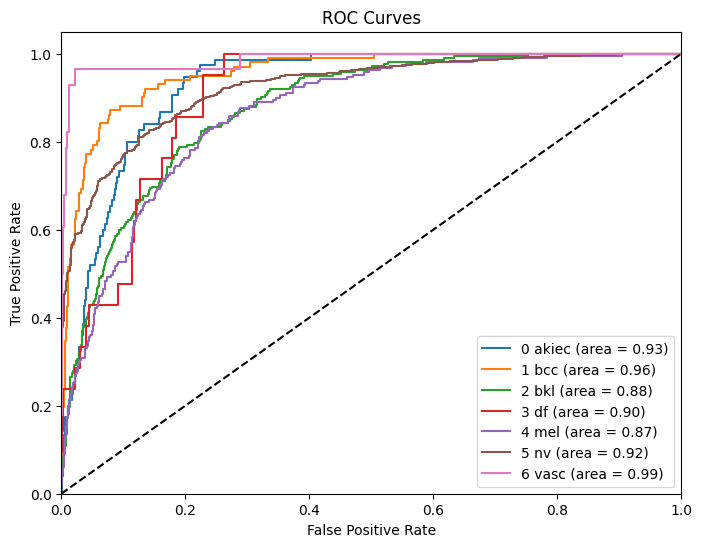

In [18]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [19]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [20]:
# 7 Class
metrics_hiba_1 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.557927   0.390805  0.153846  0.220779  0.682862
1      1           0.554439   0.403974  0.179412  0.248473  0.710979
2      2           0.558097   0.117647  0.204545  0.149378  0.659671
3      3           0.485531   0.000000  0.000000  0.000000  0.554531
4      4           0.548059   0.462687  0.122530  0.193750  0.662437
5      5           0.719086   0.535433  0.903654  0.672435  0.825847
6      6           0.539873   0.072165  0.137255  0.094595  0.570995

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.243035
1  Macro Avg Precision  0.283244
2     Macro Avg Recall  0.243035
3         Macro Avg F1  0.225630
4    Macro Avg Ovr AUC  0.666760


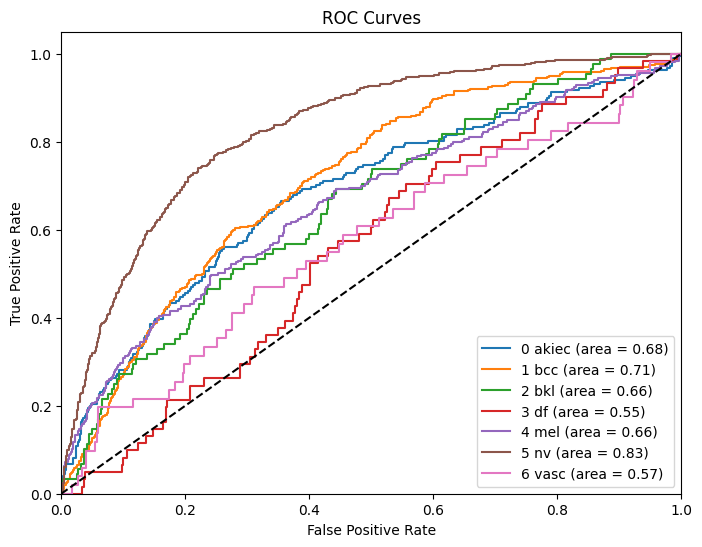

In [21]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [22]:
# Binary
grouped_on_skintype_1 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.7329909256343171


In [23]:
grouped_on_skintype_1.overall

Balanced Acc    0.603183
Precision       0.777049
Recall          0.291155
F1              0.423592
FNR             0.708845
FPR             0.084788
dtype: float64

In [24]:
grouped_on_skintype_1.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.627798,0.888889,0.328767,0.480000,0.671233,0.073171
II,0.600297,0.827907,0.282092,0.420804,0.717908,0.081498
III,0.590862,0.461538,0.281250,0.349515,0.718750,0.099526
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.635487,0.708333,0.369565,0.485714,0.630435,0.098592


In [25]:
max_min_diff(grouped_on_skintype_1.by_group)

,Difference
Balanced Acc,0.036936
Precision,0.427350
Recall,0.047517
F1,0.130485
FNR,0.047517
FPR,0.026355


# Experiment 1-2: Finetune Pretrained Weights

In [26]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

### HAM10000 Test Set

In [27]:
model_path = 'Inception_Models_F1/inceptionv3_model_2_2.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [28]:
metrics_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.769160   0.719298  0.546667  0.621212  0.964695
1      1           0.836560   0.784091  0.683168  0.730159  0.982235
2      2           0.847038   0.636015  0.747748  0.687371  0.951573
3      3           0.710481   0.375000  0.428571  0.400000  0.933947
4      4           0.685386   0.540373  0.412322  0.467742  0.873118
5      5           0.867483   0.905386  0.932534  0.918759  0.953576
6      6           0.964031   0.962963  0.928571  0.945455  0.999891

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.668512
1  Macro Avg Precision  0.703304
2     Macro Avg Recall  0.668512
3         Macro Avg F1  0.681528
4    Macro Avg Ovr AUC  0.951291


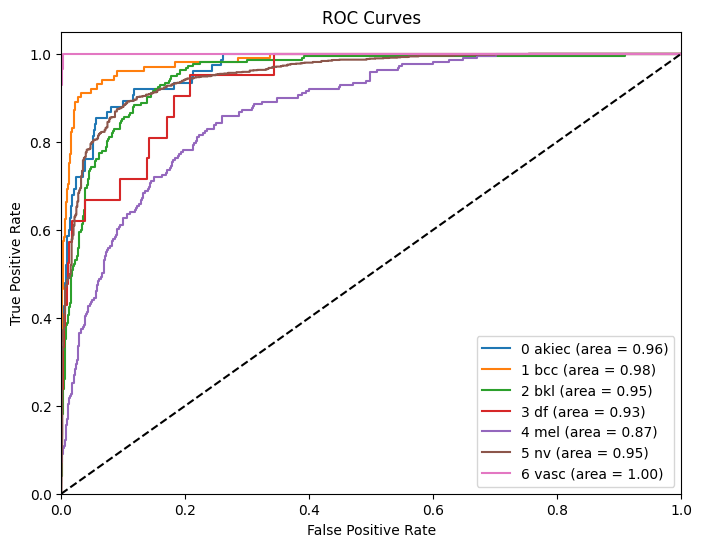

In [29]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [30]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [31]:
# 7 Class
metrics_hiba_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.563863   0.364486  0.176471  0.237805  0.755303
1      1           0.582653   0.772152  0.179412  0.291169  0.783224
2      2           0.601827   0.137931  0.318182  0.192440  0.690661
3      3           0.597707   0.133333  0.262295  0.176796  0.606726
4      4           0.579904   0.605263  0.181818  0.279635  0.762161
5      5           0.752982   0.561943  0.941860  0.703911  0.887816
6      6           0.594205   0.454545  0.196078  0.273973  0.720065

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.322302
1  Macro Avg Precision  0.432808
2     Macro Avg Recall  0.322302
3         Macro Avg F1  0.307961
4    Macro Avg Ovr AUC  0.743708


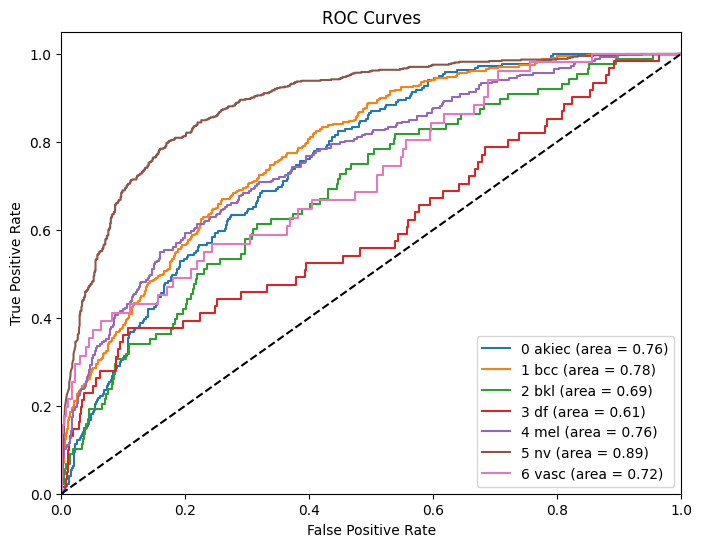

In [32]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [33]:
# Binary
grouped_on_skintype_2 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8511414951564578


In [34]:
grouped_on_skintype_2.overall

Balanced Acc    0.633704
Precision       0.916031
Recall          0.294840
F1              0.446097
FNR             0.705160
FPR             0.027431
dtype: float64

In [35]:
grouped_on_skintype_2.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.624791,0.952381,0.273973,0.425532,0.726027,0.024390
II,0.620255,0.915789,0.275753,0.423873,0.724247,0.035242
III,0.693646,0.866667,0.406250,0.553191,0.593750,0.018957
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.710349,0.952381,0.434783,0.597015,0.565217,0.014085


In [36]:
max_min_diff(grouped_on_skintype_2.by_group)

,Difference
Balanced Acc,0.073391
Precision,0.085714
Recall,0.132277
F1,0.129318
FNR,0.132277
FPR,0.016285


# Experiment 1-3: Linear Probing

In [37]:
class InceptionV3LP(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LP, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        for param in self.inception.parameters():
            param.requires_grad = False
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

### HAM10000 Test Set

In [38]:
model_path = 'Inception_Models_F1/inceptionv3_model_3.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [39]:
metrics_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.564058   0.500000  0.133333  0.210526  0.917872
1      1           0.685666   0.582090  0.386139  0.464286  0.933028
2      2           0.634196   0.421053  0.324324  0.366412  0.838245
3      3           0.500000   0.000000  0.000000  0.000000  0.785992
4      4           0.593878   0.543210  0.208531  0.301370  0.811653
5      5           0.703893   0.778450  0.964018  0.861353  0.892555
6      6           0.517857   1.000000  0.035714  0.068966  0.951775

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.293151
1  Macro Avg Precision  0.546400
2     Macro Avg Recall  0.293151
3         Macro Avg F1  0.324702
4    Macro Avg Ovr AUC  0.875874


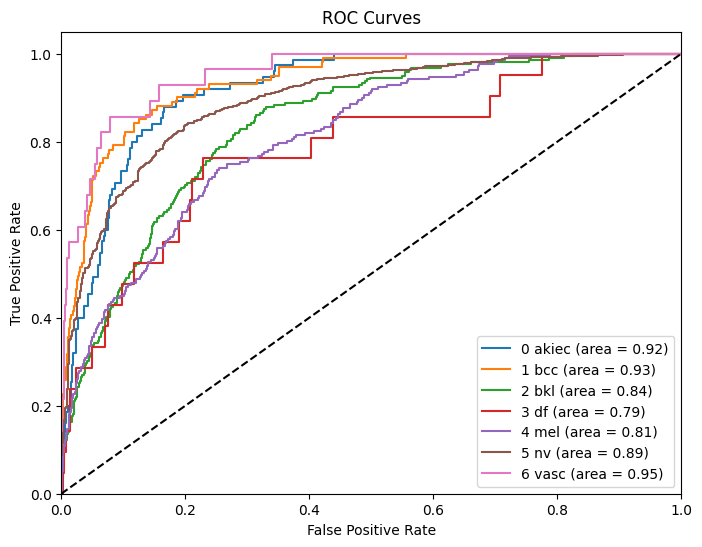

In [40]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [41]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [42]:
# 7 Class
metrics_hiba_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.499149   0.117647  0.009050  0.016807  0.652836
1      1           0.508727   0.636364  0.020588  0.039886  0.715513
2      2           0.478195   0.011765  0.011364  0.011561  0.533578
3      3           0.500000   0.000000  0.000000  0.000000  0.546434
4      4           0.505621   0.260870  0.023715  0.043478  0.644295
5      5           0.560443   0.403378  0.991694  0.573487  0.784640
6      6           0.500000   0.000000  0.000000  0.000000  0.638339

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.150916
1  Macro Avg Precision  0.204289
2     Macro Avg Recall  0.150916
3         Macro Avg F1  0.097888
4    Macro Avg Ovr AUC  0.645090


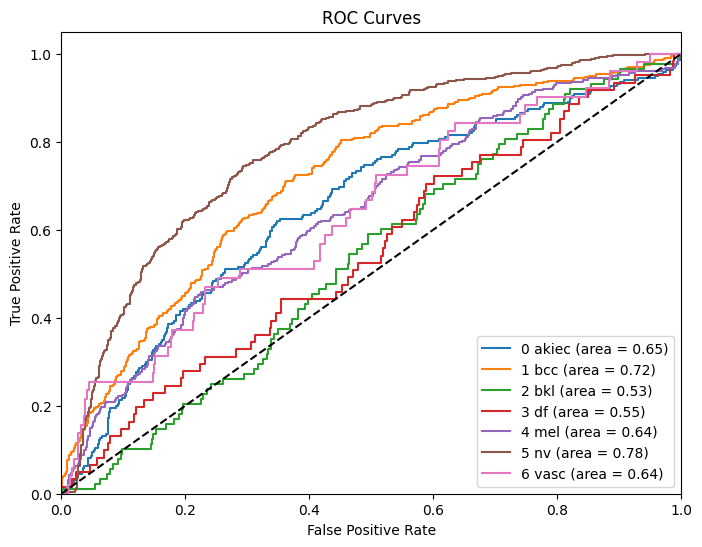

In [43]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [44]:
# Binary
grouped_on_skintype_3 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.7621057920309791


In [45]:
grouped_on_skintype_3.overall

Balanced Acc    0.522663
Precision       0.862745
Recall          0.054054
F1              0.101734
FNR             0.945946
FPR             0.008728
dtype: float64

In [46]:
grouped_on_skintype_3.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.527397,1.000000,0.054795,0.103896,0.945205,0.000000
II,0.519541,0.846154,0.052298,0.098507,0.947702,0.013216
III,0.546875,1.000000,0.093750,0.171429,0.906250,0.000000
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.503827,0.500000,0.021739,0.041667,0.978261,0.014085


In [47]:
max_min_diff(grouped_on_skintype_3.by_group)

,Difference
Balanced Acc,0.027334
Precision,0.153846
Recall,0.041452
F1,0.072921
FNR,0.041452
FPR,0.013216


# Experiment 2-1: Data Augmentation

In [59]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

## Experiment 2-1:

### HAM10000 Test Set

In [60]:
model_path = 'Inception_Models_F1/inceptionv3_model_5.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [61]:
metrics_5 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.785509   0.594595  0.586667  0.590604  0.962573
1      1           0.866792   0.815217  0.742574  0.777202  0.980177
2      2           0.798633   0.654378  0.639640  0.646925  0.930643
3      3           0.782416   0.480000  0.571429  0.521739  0.975792
4      4           0.673885   0.666667  0.369668  0.475610  0.888475
5      5           0.852142   0.885794  0.953523  0.918412  0.952995
6      6           0.981125   0.870968  0.964286  0.915254  0.999709

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.689684
1  Macro Avg Precision  0.709660
2     Macro Avg Recall  0.689684
3         Macro Avg F1  0.692249
4    Macro Avg Ovr AUC  0.955766


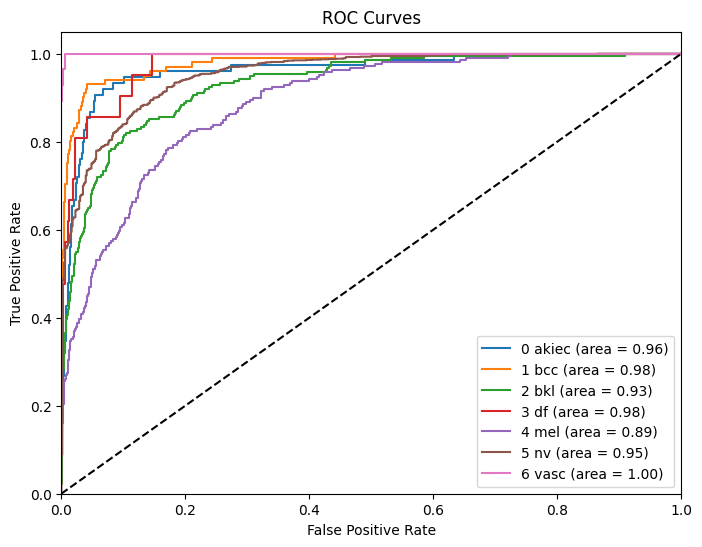

In [62]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [63]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [64]:
# 7 Class
metrics_hiba_5 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.611598   0.436620  0.280543  0.341598  0.825641
1      1           0.613447   0.636364  0.267647  0.376812  0.814685
2      2           0.587191   0.123223  0.295455  0.173913  0.718958
3      3           0.637895   0.375000  0.295082  0.330275  0.760793
4      4           0.632080   0.630252  0.296443  0.403226  0.807864
5      5           0.813374   0.633260  0.955150  0.761589  0.922121
6      6           0.637474   0.333333  0.294118  0.312500  0.888718

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.383491
1  Macro Avg Precision  0.452579
2     Macro Avg Recall  0.383491
3         Macro Avg F1  0.385702
4    Macro Avg Ovr AUC  0.819826


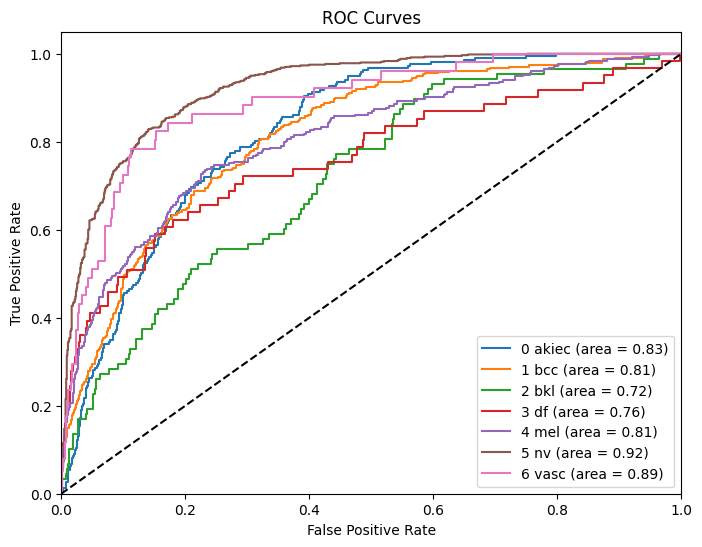

In [65]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [66]:
# Binary
grouped_on_skintype_5 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8756854791767509


In [67]:
grouped_on_skintype_5.overall

Balanced Acc    0.717215
Precision       0.938119
Recall          0.465602
F1              0.622332
FNR             0.534398
FPR             0.031172
dtype: float64

In [68]:
grouped_on_skintype_5.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.783829,0.957447,0.616438,0.750000,0.383562,0.048780
II,0.701079,0.945205,0.437401,0.598050,0.562599,0.035242
III,0.735078,0.911765,0.484375,0.632653,0.515625,0.014218
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.765309,0.870968,0.586957,0.701299,0.413043,0.056338


In [69]:
max_min_diff(grouped_on_skintype_5.by_group)

,Difference
Balanced Acc,0.082750
Precision,0.045682
Recall,0.179037
F1,0.151950
FNR,0.179037
FPR,0.034562


## Experiment 2-2:

### HAM10000 Test Set

In [70]:
model_path = 'Inception_Models_F1/inceptionv3_model_5_2.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [71]:
metrics_5_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.729421   0.700000  0.466667  0.560000  0.957134
1      1           0.899066   0.759259  0.811881  0.784689  0.988743
2      2           0.779524   0.767857  0.581081  0.661538  0.943047
3      3           0.780894   0.387097  0.571429  0.461538  0.971588
4      4           0.720684   0.632911  0.473934  0.542005  0.904591
5      5           0.858524   0.887586  0.964768  0.924569  0.961128
6      6           0.964031   0.962963  0.928571  0.945455  0.999709

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.685476
1  Macro Avg Precision  0.728239
2     Macro Avg Recall  0.685476
3         Macro Avg F1  0.697114
4    Macro Avg Ovr AUC  0.960849


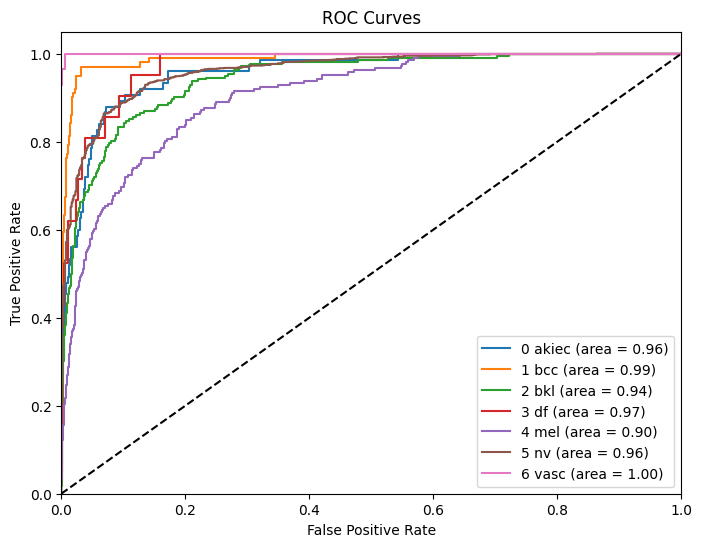

In [72]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [73]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [74]:
# 7 Class
metrics_hiba_5_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.589220   0.411290  0.230769  0.295652  0.813789
1      1           0.586972   0.650943  0.202941  0.309417  0.841326
2      2           0.600161   0.163399  0.284091  0.207469  0.716958
3      3           0.572642   0.256410  0.163934  0.200000  0.674229
4      4           0.622424   0.644860  0.272727  0.383333  0.808303
5      5           0.738605   0.541784  0.958472  0.692262  0.914804
6      6           0.685316   0.863636  0.372549  0.520548  0.894945

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.355069
1  Macro Avg Precision  0.504618
2     Macro Avg Recall  0.355069
3         Macro Avg F1  0.372669
4    Macro Avg Ovr AUC  0.809193


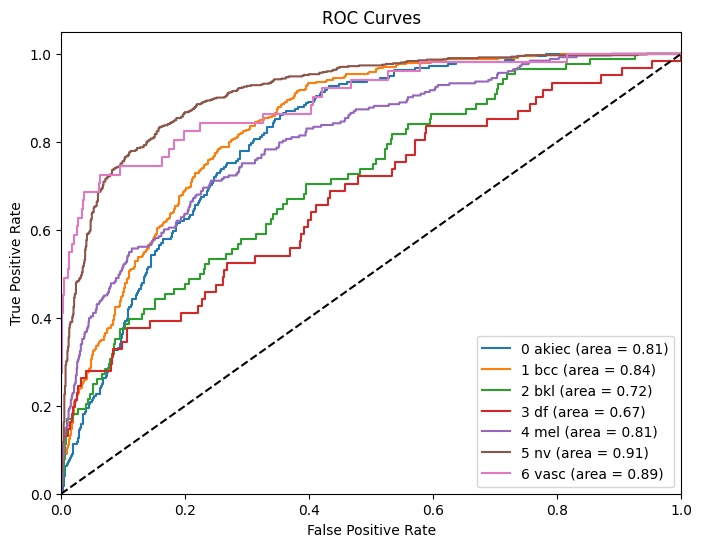

In [75]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [76]:
# Binary
grouped_on_skintype_5_2 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.9013338888650609


In [77]:
grouped_on_skintype_5_2.overall

Balanced Acc    0.681011
Precision       0.937685
Recall          0.388206
F1              0.549088
FNR             0.611794
FPR             0.026185
dtype: float64

In [78]:
grouped_on_skintype_5_2.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.732877,1.00000,0.465753,0.635514,0.534247,0.000000
II,0.669209,0.94332,0.369255,0.530752,0.630745,0.030837
III,0.709271,0.87500,0.437500,0.583333,0.562500,0.018957
IV,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
nan,0.707134,0.87500,0.456522,0.600000,0.543478,0.042254


In [79]:
max_min_diff(grouped_on_skintype_5_2.by_group)

,Difference
Balanced Acc,0.063668
Precision,0.125000
Recall,0.096498
F1,0.104762
FNR,0.096498
FPR,0.030837


## Experiment 2-3:

### HAM10000 Test Set

In [80]:
model_path = 'Inception_Models_F1/inceptionv3_model_5_3.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [81]:
metrics_5_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.764987   0.561644  0.546667  0.554054  0.968131
1      1           0.870949   0.791667  0.752475  0.771574  0.986711
2      2           0.782333   0.744318  0.590090  0.658291  0.940075
3      3           0.781148   0.400000  0.571429  0.470588  0.960450
4      4           0.757814   0.540179  0.573460  0.556322  0.903497
5      5           0.878141   0.915805  0.929535  0.922619  0.958473
6      6           0.997200   0.717949  1.000000  0.835821  0.999927

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.709094
1  Macro Avg Precision  0.667366
2     Macro Avg Recall  0.709094
3         Macro Avg F1  0.681324
4    Macro Avg Ovr AUC  0.959609


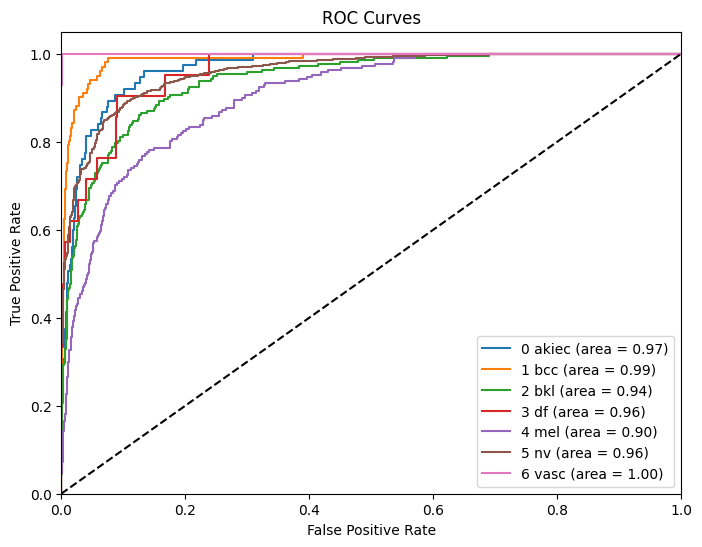

In [82]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [83]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [84]:
# 7 Class
metrics_hiba_5_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.516285   0.314286  0.049774  0.085938  0.812728
1      1           0.661802   0.541985  0.417647  0.471761  0.811371
2      2           0.611167   0.237624  0.272727  0.253968  0.724491
3      3           0.586785   0.250000  0.196721  0.220183  0.613547
4      4           0.653572   0.544379  0.363636  0.436019  0.801864
5      5           0.781814   0.603692  0.923588  0.730138  0.894644
6      6           0.768020   0.362500  0.568627  0.442748  0.910004

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.398960
1  Macro Avg Precision  0.407781
2     Macro Avg Recall  0.398960
3         Macro Avg F1  0.377251
4    Macro Avg Ovr AUC  0.795521


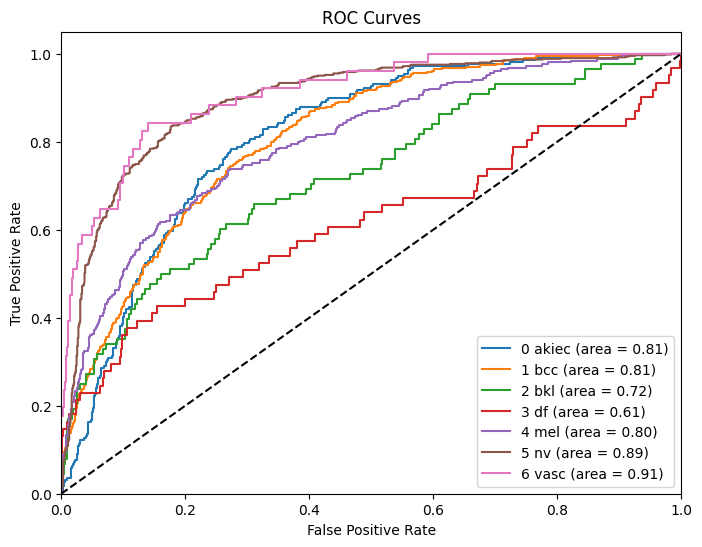

In [85]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [86]:
# Binary
grouped_on_skintype_5_3 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.883761113187547


In [87]:
grouped_on_skintype_5_3.overall

Balanced Acc    0.730545
Precision       0.903433
Recall          0.517199
F1              0.657813
FNR             0.482801
FPR             0.056110
dtype: float64

In [88]:
grouped_on_skintype_5_3.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.789175,0.977778,0.602740,0.745763,0.397260,0.024390
II,0.709647,0.895184,0.500792,0.642276,0.499208,0.081498
III,0.751407,0.850000,0.531250,0.653846,0.468750,0.028436
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.786436,0.964286,0.586957,0.729730,0.413043,0.014085


In [89]:
max_min_diff(grouped_on_skintype_5_3.by_group)

,Difference
Balanced Acc,0.079527
Precision,0.127778
Recall,0.101947
F1,0.103486
FNR,0.101947
FPR,0.057108


## Experiment 2-4:

### HAM10000 Dataset

In [90]:
model_path = 'Inception_Models_F1/inceptionv3_model_5_4.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [91]:
metrics_5_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.825769   0.632911  0.666667  0.649351  0.974300
1      1           0.923818   0.769912  0.861386  0.813084  0.990151
2      2           0.818629   0.688073  0.675676  0.681818  0.946531
3      3           0.851055   0.384615  0.714286  0.500000  0.974536
4      4           0.683925   0.689076  0.388626  0.496970  0.899971
5      5           0.871575   0.904591  0.945277  0.924487  0.955265
6      6           0.945156   0.833333  0.892857  0.862069  0.995381

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.734968
1  Macro Avg Precision  0.700359
2     Macro Avg Recall  0.734968
3         Macro Avg F1  0.703968
4    Macro Avg Ovr AUC  0.962305


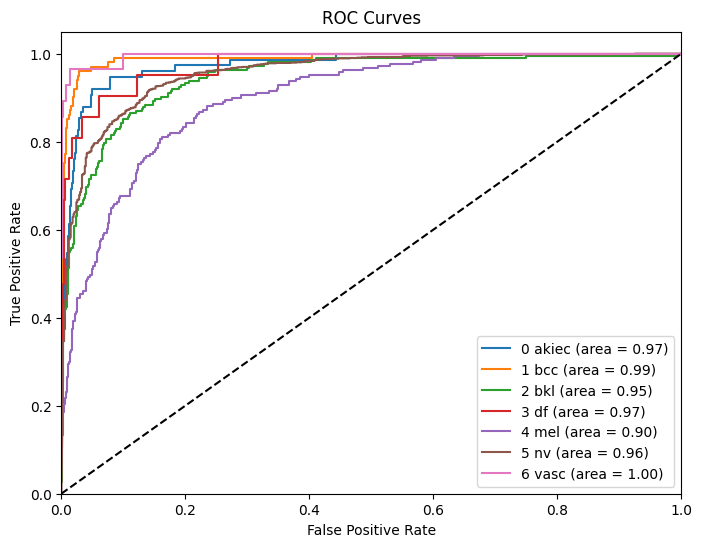

In [92]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [93]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [94]:
# 7 Class
metrics_hiba_5_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.531293   0.459459  0.076923  0.131783  0.782559
1      1           0.654140   0.632653  0.364706  0.462687  0.839100
2      2           0.556342   0.121429  0.193182  0.149123  0.653238
3      3           0.541300   0.122807  0.114754  0.118644  0.625281
4      4           0.582105   0.657143  0.181818  0.284830  0.788901
5      5           0.740785   0.541899  0.966777  0.694511  0.909591
6      6           0.668803   0.428571  0.352941  0.387097  0.803721

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.321586
1  Macro Avg Precision  0.423423
2     Macro Avg Recall  0.321586
3         Macro Avg F1  0.318382
4    Macro Avg Ovr AUC  0.771770


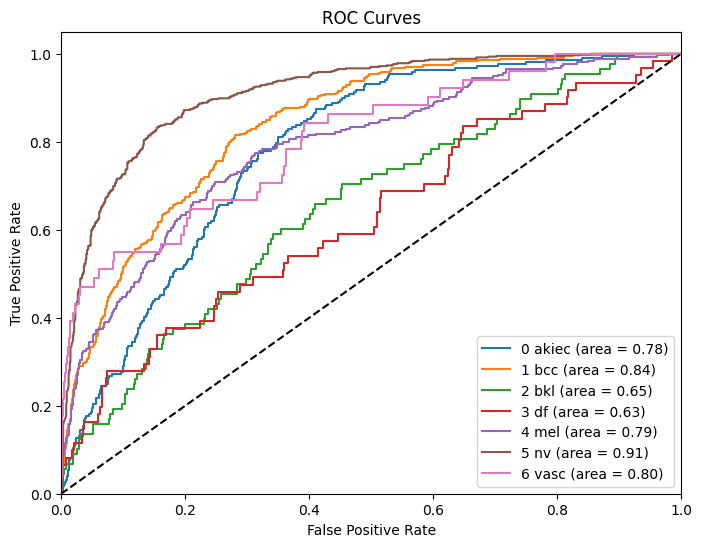

In [95]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [96]:
# Binary
grouped_on_skintype_5_4 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.887483380002083


In [97]:
grouped_on_skintype_5_4.overall

Balanced Acc    0.660126
Precision       0.930693
Recall          0.346437
F1              0.504924
FNR             0.653563
FPR             0.026185
dtype: float64

In [98]:
grouped_on_skintype_5_4.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.719178,1.000000,0.438356,0.609524,0.561644,0.000000
II,0.641341,0.922374,0.320127,0.475294,0.679873,0.037445
III,0.719453,0.906250,0.453125,0.604167,0.546875,0.014218
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.699479,0.950000,0.413043,0.575758,0.586957,0.014085


In [99]:
max_min_diff(grouped_on_skintype_5_4.by_group)

,Difference
Balanced Acc,0.078113
Precision,0.093750
Recall,0.132998
F1,0.134230
FNR,0.132998
FPR,0.037445


# EXPERIMENT 3: Weight Decay

In [100]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

## Experiment 3-1: 1e-5

### HAM10000 Test Set

In [101]:
model_path = 'Inception_Models_F1/inceptionv3_model_6.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [102]:
metrics_6 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.760407   0.625000  0.533333  0.575540  0.960083
1      1           0.847710   0.685714  0.712871  0.699029  0.981104
2      2           0.791640   0.826087  0.599099  0.694517  0.938556
3      3           0.784446   0.705882  0.571429  0.631579  0.937112
4      4           0.727074   0.601156  0.492891  0.541667  0.908077
5      5           0.849102   0.883333  0.953523  0.917087  0.956677
6      6           0.962758   0.812500  0.928571  0.866667  0.999400

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.684531
1  Macro Avg Precision  0.734239
2     Macro Avg Recall  0.684531
3         Macro Avg F1  0.703726
4    Macro Avg Ovr AUC  0.954430


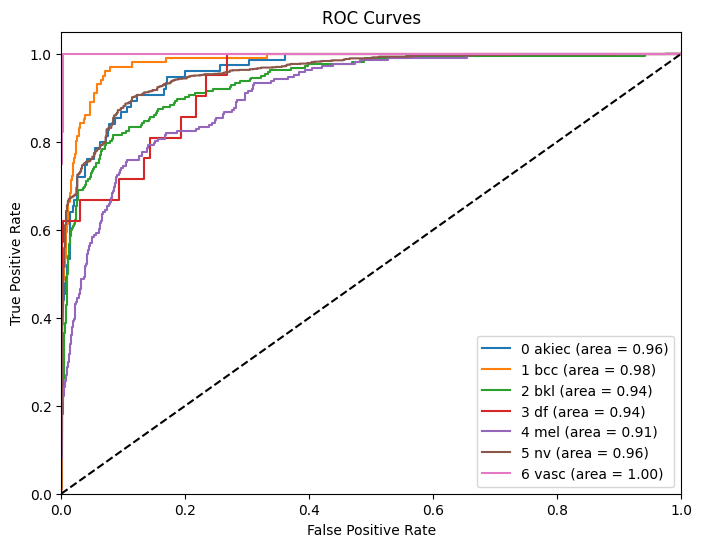

In [103]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [104]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [105]:
# 7 Class
metrics_hiba_6 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.556605   0.357143  0.158371  0.219436  0.779166
1      1           0.603739   0.656000  0.241176  0.352688  0.796874
2      2           0.579397   0.146853  0.238636  0.181818  0.650672
3      3           0.553355   0.173913  0.131148  0.149533  0.544083
4      4           0.608081   0.642105  0.241107  0.350575  0.751548
5      5           0.732740   0.533394  0.968439  0.687906  0.887146
6      6           0.596122   0.625000  0.196078  0.298507  0.754482

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.310708
1  Macro Avg Precision  0.447773
2     Macro Avg Recall  0.310708
3         Macro Avg F1  0.320066
4    Macro Avg Ovr AUC  0.737710


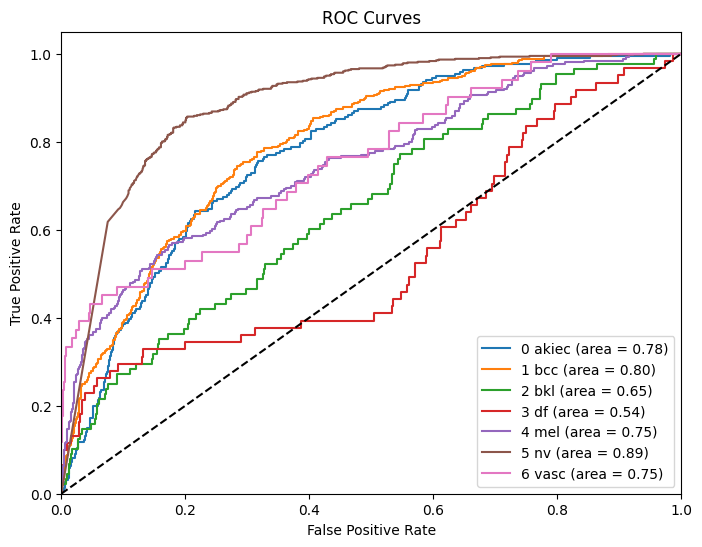

In [106]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [107]:
# Binary
grouped_on_skintype_6 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8743252434025502


In [108]:
grouped_on_skintype_6.overall

Balanced Acc    0.668102
Precision       0.930818
Recall          0.363636
F1              0.522968
FNR             0.636364
FPR             0.027431
dtype: float64

In [109]:
grouped_on_skintype_6.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.678082,1.000000,0.356164,0.525253,0.643836,0.000000
II,0.656705,0.932203,0.348653,0.507497,0.651347,0.035242
III,0.678021,0.857143,0.375000,0.521739,0.625000,0.018957
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.768524,0.928571,0.565217,0.702703,0.434783,0.028169


In [110]:
max_min_diff(grouped_on_skintype_6.by_group)

,Difference
Balanced Acc,0.021377
Precision,0.142857
Recall,0.026347
F1,0.017755
FNR,0.026347
FPR,0.035242


## Experiment 3-2: 1e-4

### HAM10000 Test Set

In [111]:
model_path = 'Inception_Models_F1/inceptionv3_model_6_2.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [112]:
metrics_6_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.861189   0.723684  0.733333  0.728477  0.978612
1      1           0.881644   0.821053  0.772277  0.795918  0.991162
2      2           0.809070   0.727273  0.648649  0.685714  0.952446
3      3           0.689715   0.727273  0.380952  0.500000  0.925708
4      4           0.678434   0.560811  0.393365  0.462396  0.892821
5      5           0.849518   0.885234  0.948276  0.915671  0.950941
6      6           0.980106   0.771429  0.964286  0.857143  0.999600

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.691591
1  Macro Avg Precision  0.745251
2     Macro Avg Recall  0.691591
3         Macro Avg F1  0.706474
4    Macro Avg Ovr AUC  0.955899


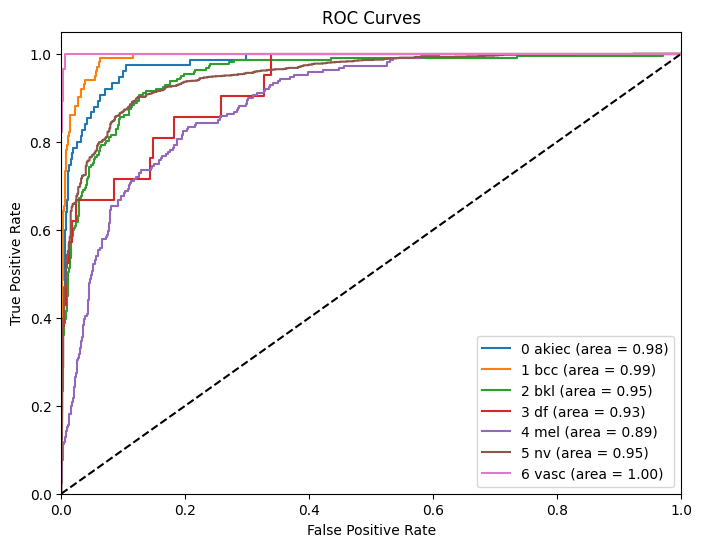

In [113]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [114]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [115]:
# 7 Class
metrics_hiba_6_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.599434   0.383117  0.266968  0.314667  0.810717
1      1           0.540983   0.789474  0.088235  0.158730  0.826206
2      2           0.607181   0.141463  0.329545  0.197952  0.680606
3      3           0.539856   0.171429  0.098361  0.125000  0.518180
4      4           0.651004   0.522727  0.363636  0.428904  0.778627
5      5           0.774730   0.584098  0.951827  0.723942  0.908617
6      6           0.622978   0.481481  0.254902  0.333333  0.753480

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.336211
1  Macro Avg Precision  0.439113
2     Macro Avg Recall  0.336211
3         Macro Avg F1  0.326076
4    Macro Avg Ovr AUC  0.753776


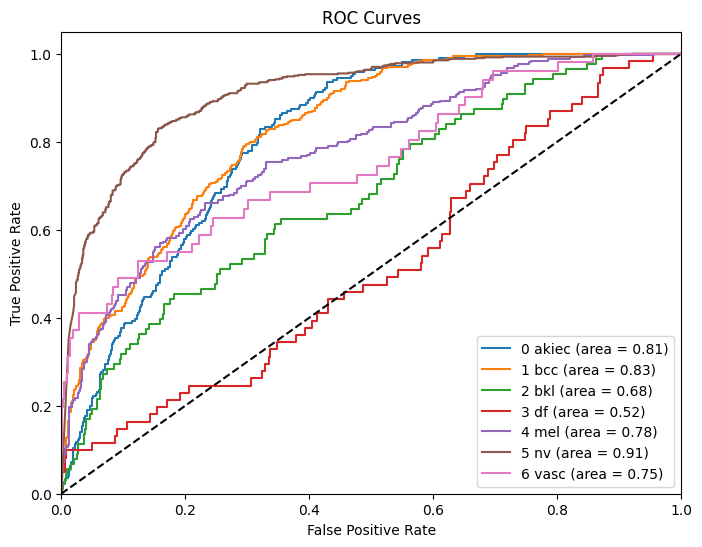

In [116]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [117]:
# Binary
grouped_on_skintype_6_2 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8853388641418566


In [118]:
grouped_on_skintype_6_2.overall

Balanced Acc    0.677774
Precision       0.894022
Recall          0.404177
F1              0.556684
FNR             0.595823
FPR             0.048628
dtype: float64

In [119]:
grouped_on_skintype_6_2.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.672736,0.964286,0.369863,0.534653,0.630137,0.024390
II,0.666294,0.904412,0.389857,0.544850,0.610143,0.057269
III,0.754480,0.813953,0.546875,0.654206,0.453125,0.037915
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.700092,0.840000,0.456522,0.591549,0.543478,0.056338


In [120]:
max_min_diff(grouped_on_skintype_6_2.by_group)

,Difference
Balanced Acc,0.088186
Precision,0.150332
Recall,0.177012
F1,0.119552
FNR,0.177012
FPR,0.032878


## Experiment 3-3: 1e-6

### HAM10000 Test Set

In [121]:
model_path = 'Inception_Models_F1/inceptionv3_model_6_3.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [122]:
metrics_6_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.722754   0.693878  0.453333  0.548387  0.947397
1      1           0.903488   0.747748  0.821782  0.783019  0.985455
2      2           0.801466   0.712121  0.635135  0.671429  0.942197
3      3           0.663623   0.368421  0.333333  0.350000  0.951366
4      4           0.686386   0.581081  0.407583  0.479109  0.892185
5      5           0.860469   0.891213  0.958021  0.923410  0.955952
6      6           0.998727   0.848485  1.000000  0.918033  0.999618

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.658455
1  Macro Avg Precision  0.691850
2     Macro Avg Recall  0.658455
3         Macro Avg F1  0.667627
4    Macro Avg Ovr AUC  0.953453


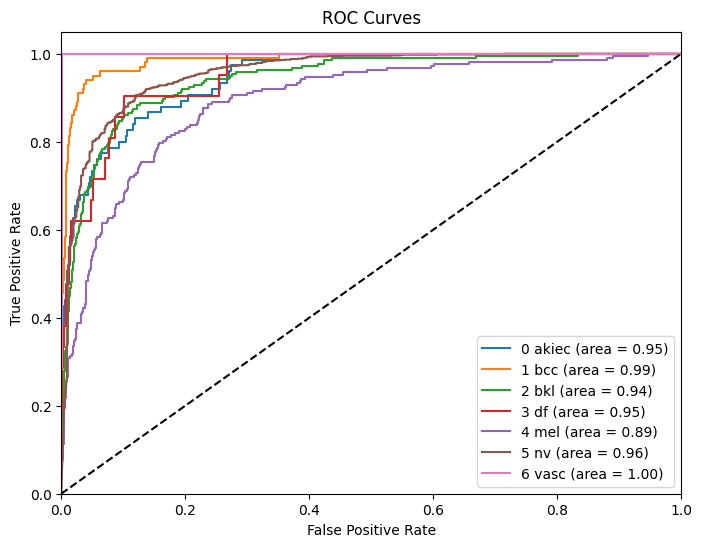

In [123]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [124]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [125]:
# 7 Class
metrics_hiba_6_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.539491   0.396552  0.104072  0.164875  0.795096
1      1           0.593735   0.699029  0.211765  0.325056  0.848140
2      2           0.580795   0.186275  0.215909  0.200000  0.718162
3      3           0.566855   0.175439  0.163934  0.169492  0.606220
4      4           0.627206   0.463277  0.324111  0.381395  0.721197
5      5           0.741901   0.544769  0.960133  0.695129  0.911866
6      6           0.643444   0.275862  0.313725  0.293578  0.770244

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.327664
1  Macro Avg Precision  0.391600
2     Macro Avg Recall  0.327664
3         Macro Avg F1  0.318504
4    Macro Avg Ovr AUC  0.767275


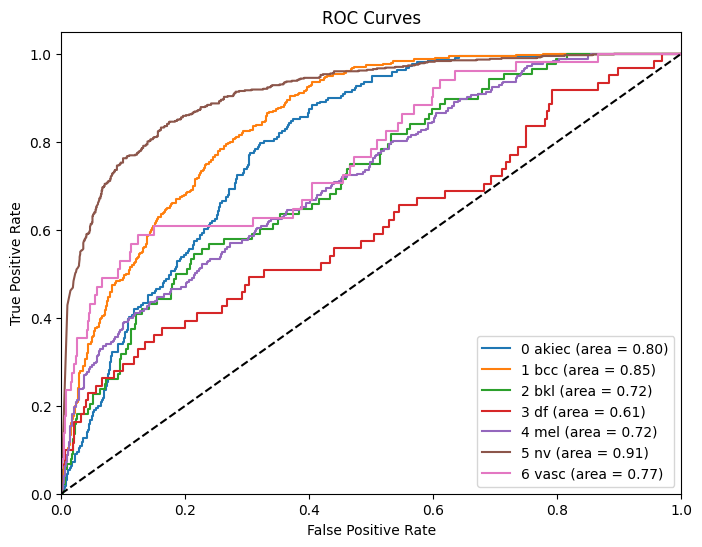

In [126]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [127]:
# Binary
grouped_on_skintype_6_3 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8849773600397042


In [128]:
grouped_on_skintype_6_3.overall

Balanced Acc    0.675437
Precision       0.923077
Recall          0.383292
F1              0.541667
FNR             0.616708
FPR             0.032419
dtype: float64

In [129]:
grouped_on_skintype_6_3.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.706983,0.969697,0.438356,0.603774,0.561644,0.024390
II,0.666080,0.925490,0.374010,0.532731,0.625990,0.041850
III,0.711641,0.903226,0.437500,0.589474,0.562500,0.014218
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.652786,0.842105,0.347826,0.492308,0.652174,0.042254


In [130]:
max_min_diff(grouped_on_skintype_6_3.by_group)

,Difference
Balanced Acc,0.045561
Precision,0.066471
Recall,0.064347
F1,0.071042
FNR,0.064347
FPR,0.027632


## Experiment 3-4: 1e-7

### HAM10000 Test Set

In [131]:
model_path = 'Inception_Models_F1/inceptionv3_model_6_4.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [132]:
metrics_6_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.749943   0.745098  0.506667  0.603175  0.953469
1      1           0.889694   0.769231  0.792079  0.780488  0.977104
2      2           0.778943   0.696809  0.590090  0.639024  0.938097
3      3           0.713271   0.692308  0.428571  0.529412  0.951898
4      4           0.747493   0.524664  0.554502  0.539171  0.893079
5      5           0.857615   0.897399  0.931034  0.913907  0.941599
6      6           0.945410   0.862069  0.892857  0.877193  0.994254

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.670829
1  Macro Avg Precision  0.741082
2     Macro Avg Recall  0.670829
3         Macro Avg F1  0.697481
4    Macro Avg Ovr AUC  0.949929


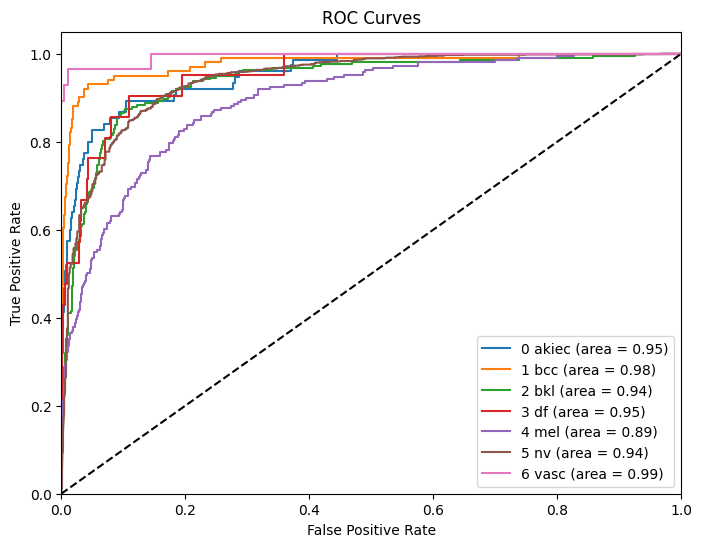

In [133]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [134]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [135]:
# 7 Class
metrics_hiba_6_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.551498   0.373494  0.140271  0.203947  0.793604
1      1           0.609621   0.666667  0.252941  0.366738  0.826056
2      2           0.551880   0.104651  0.204545  0.138462  0.683982
3      3           0.554478   0.130435  0.147541  0.138462  0.637331
4      4           0.632282   0.548611  0.312253  0.397985  0.766958
5      5           0.759677   0.572301  0.933555  0.709596  0.903077
6      6           0.670400   0.486486  0.352941  0.409091  0.877667

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.334864
1  Macro Avg Precision  0.411807
2     Macro Avg Recall  0.334864
3         Macro Avg F1  0.337754
4    Macro Avg Ovr AUC  0.784096


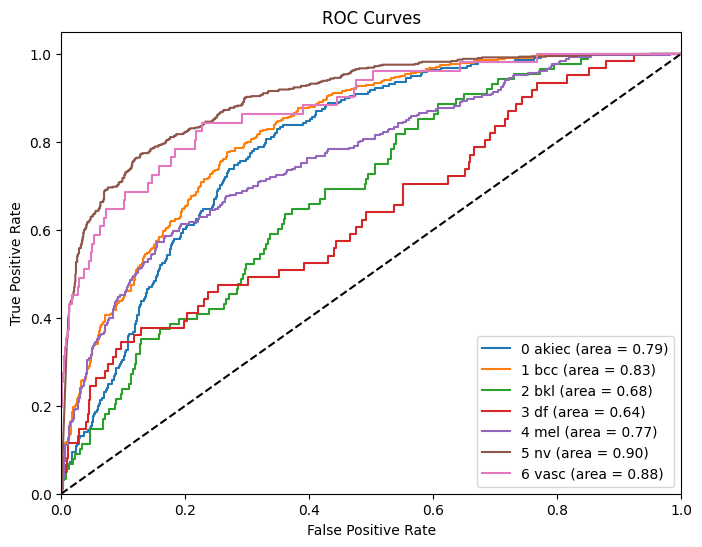

In [136]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [137]:
# Binary
grouped_on_skintype_6_4 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8759229077184189


In [138]:
grouped_on_skintype_6_4.overall

Balanced Acc    0.681542
Precision       0.915730
Recall          0.400491
F1              0.557265
FNR             0.599509
FPR             0.037406
dtype: float64

In [139]:
grouped_on_skintype_6_4.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.713832,0.970588,0.452055,0.616822,0.547945,0.024390
II,0.667530,0.916667,0.383518,0.540782,0.616482,0.048458
III,0.730339,0.861111,0.484375,0.620000,0.515625,0.023697
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.703307,0.909091,0.434783,0.588235,0.565217,0.028169


In [140]:
max_min_diff(grouped_on_skintype_6_4.by_group)

,Difference
Balanced Acc,0.062809
Precision,0.109477
Recall,0.100857
F1,0.079218
FNR,0.100857
FPR,0.024761


# EXPERIMENT 4: Loss Function Modification

In [141]:
class InceptionV3LF(nn.Module):
    def __init__(self, num_classes=7):
        super(InceptionV3LF, self).__init__()
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.inception(x)

## Experiment 4-1:

In [142]:
class_weights = torch.FloatTensor([5.0, 5.0, 1.0, 1.0, 5.0, 1.0, 1.0])

### HAM10000 Test Set

In [143]:
model_path = 'Inception_Models_F1/inceptionv3_model_7.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [144]:
metrics_7 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.798059   0.582278  0.613333  0.597403  0.960529
1      1           0.918339   0.754386  0.851485  0.800000  0.981737
2      2           0.780081   0.742857  0.585586  0.654912  0.943620
3      3           0.757592   0.392857  0.523810  0.448980  0.931024
4      4           0.702659   0.542857  0.450237  0.492228  0.890091
5      5           0.849256   0.890323  0.931034  0.910224  0.949869
6      6           0.909951   0.884615  0.821429  0.851852  0.998491

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.682416
1  Macro Avg Precision  0.684311
2     Macro Avg Recall  0.682416
3         Macro Avg F1  0.679371
4    Macro Avg Ovr AUC  0.950766


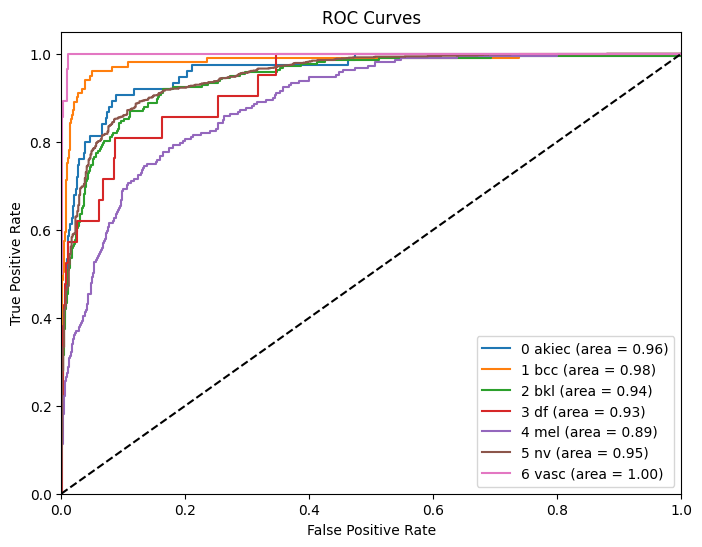

In [145]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [146]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [147]:
# 7 Class
metrics_hiba_7 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.597126   0.324873  0.289593  0.306220  0.810130
1      1           0.612461   0.726496  0.250000  0.371991  0.837735
2      2           0.577433   0.140940  0.238636  0.177215  0.670945
3      3           0.577302   0.215686  0.180328  0.196429  0.650561
4      4           0.645323   0.619403  0.328063  0.428941  0.795064
5      5           0.774470   0.590336  0.933555  0.723295  0.896026
6      6           0.626493   0.812500  0.254902  0.388060  0.731943

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.353582
1  Macro Avg Precision  0.490033
2     Macro Avg Recall  0.353582
3         Macro Avg F1  0.370307
4    Macro Avg Ovr AUC  0.770343


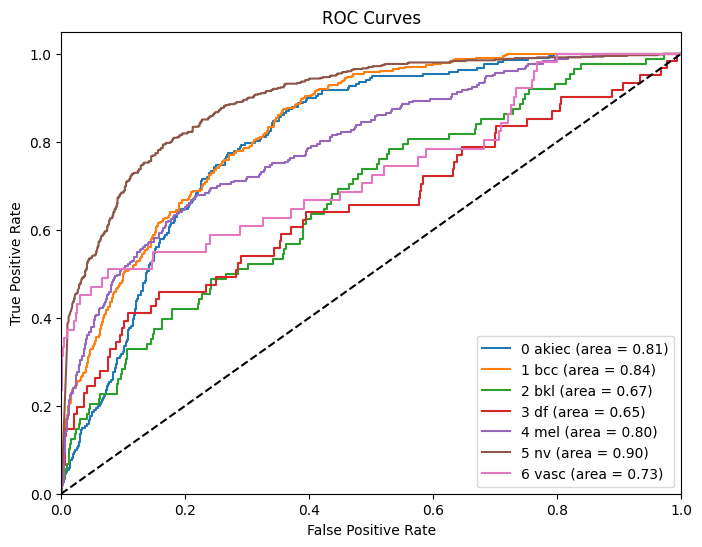

In [148]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [149]:
# Binary
grouped_on_skintype_7 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8742195494065819


In [150]:
grouped_on_skintype_7.overall

Balanced Acc    0.705874
Precision       0.875000
Recall          0.481572
F1              0.621236
FNR             0.518428
FPR             0.069825
dtype: float64

In [151]:
grouped_on_skintype_7.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.730538,0.928571,0.534247,0.678261,0.465753,0.073171
II,0.678959,0.867069,0.454834,0.596674,0.545166,0.096916
III,0.756146,0.894737,0.531250,0.666667,0.468750,0.018957
IV,0.960000,0.000000,0.000000,0.000000,0.000000,0.040000
nan,0.819657,0.888889,0.695652,0.780488,0.304348,0.056338


In [152]:
max_min_diff(grouped_on_skintype_7.by_group)

,Difference
Balanced Acc,0.077188
Precision,0.061502
Recall,0.079413
F1,0.081587
FNR,0.079413
FPR,0.077959


## Experiment 4-2:

In [153]:
class_weights = torch.FloatTensor([10.0, 10.0, 1.0, 1.0, 10.0, 1.0, 1.0])

### HAM10000 Test Set

In [154]:
model_path = 'Inception_Models_F1/inceptionv3_model_7_2.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [155]:
metrics_7_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.805248   0.602564  0.626667  0.614379  0.946646
1      1           0.887314   0.707965  0.792079  0.747664  0.979957
2      2           0.736738   0.778571  0.490991  0.602210  0.926149
3      3           0.687686   0.421053  0.380952  0.400000  0.946244
4      4           0.761677   0.504032  0.592417  0.544662  0.888286
5      5           0.862215   0.903367  0.925037  0.914074  0.943867
6      6           0.909441   0.821429  0.821429  0.821429  0.998727

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.661367
1  Macro Avg Precision  0.676997
2     Macro Avg Recall  0.661367
3         Macro Avg F1  0.663488
4    Macro Avg Ovr AUC  0.947125


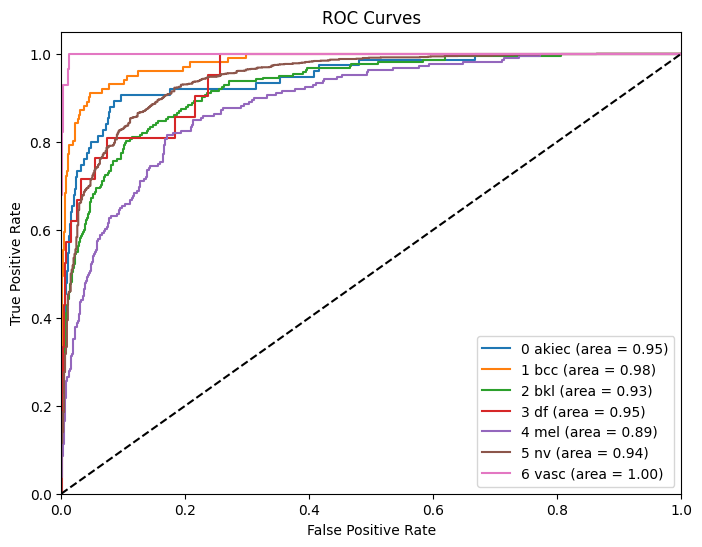

In [156]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [157]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [158]:
# 7 Class
metrics_hiba_7_2 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.563146   0.357798  0.176471  0.236364  0.762795
1      1           0.614434   0.573964  0.285294  0.381139  0.815750
2      2           0.541796   0.117117  0.147727  0.130653  0.685239
3      3           0.557535   0.242424  0.131148  0.170213  0.586358
4      4           0.606673   0.542373  0.252964  0.345013  0.745101
5      5           0.747610   0.553089  0.951827  0.699634  0.886091
6      6           0.659318   0.425000  0.333333  0.373626  0.804648

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.325538
1  Macro Avg Precision  0.401681
2     Macro Avg Recall  0.325538
3         Macro Avg F1  0.333806
4    Macro Avg Ovr AUC  0.755140


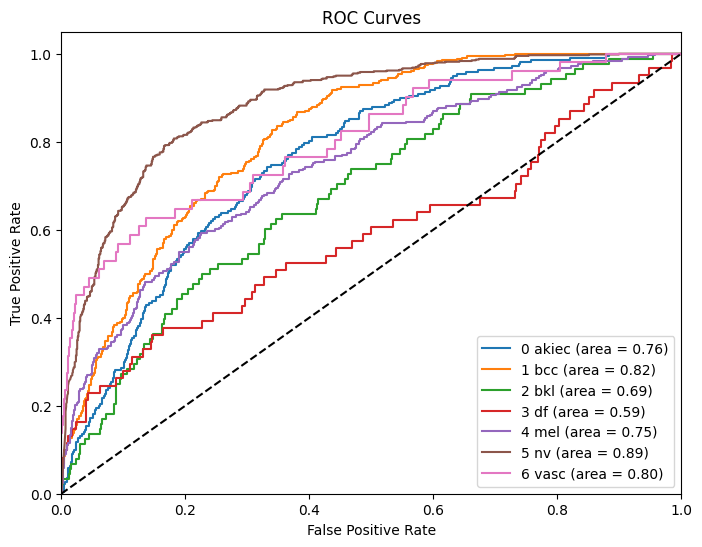

In [159]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [160]:
# Binary
grouped_on_skintype_7_2 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8775328264106319


In [161]:
grouped_on_skintype_7_2.overall

Balanced Acc    0.702399
Precision       0.916667
Recall          0.445946
F1              0.600000
FNR             0.554054
FPR             0.041147
dtype: float64

In [162]:
grouped_on_skintype_7_2.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.701637,0.942857,0.452055,0.611111,0.547945,0.048780
II,0.687031,0.920962,0.424723,0.581345,0.575277,0.050661
III,0.733412,0.820513,0.500000,0.621359,0.500000,0.033175
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.819045,0.967742,0.652174,0.779221,0.347826,0.014085


In [163]:
max_min_diff(grouped_on_skintype_7_2.by_group)

,Difference
Balanced Acc,0.046381
Precision,0.122344
Recall,0.075277
F1,0.040014
FNR,0.075277
FPR,0.017485


## Experiment 4-3:

In [164]:
class_weights = torch.FloatTensor([15.0, 15.0, 1.0, 1.0, 15.0, 1.0, 1.0])

### HAM10000 Test Set

In [165]:
model_path = 'Inception_Models_F1/inceptionv3_model_7_3.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [166]:
metrics_7_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.769306   0.506024  0.560000  0.531646  0.935309
1      1           0.932133   0.735537  0.881188  0.801802  0.979884
2      2           0.784303   0.741573  0.594595  0.660000  0.939769
3      3           0.594477   0.571429  0.190476  0.285714  0.889638
4      4           0.737419   0.479167  0.545024  0.509978  0.882344
5      5           0.862692   0.908751  0.910795  0.909772  0.945325
6      6           0.928062   0.923077  0.857143  0.888889  0.999254

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.648460
1  Macro Avg Precision  0.695080
2     Macro Avg Recall  0.648460
3         Macro Avg F1  0.655400
4    Macro Avg Ovr AUC  0.938789


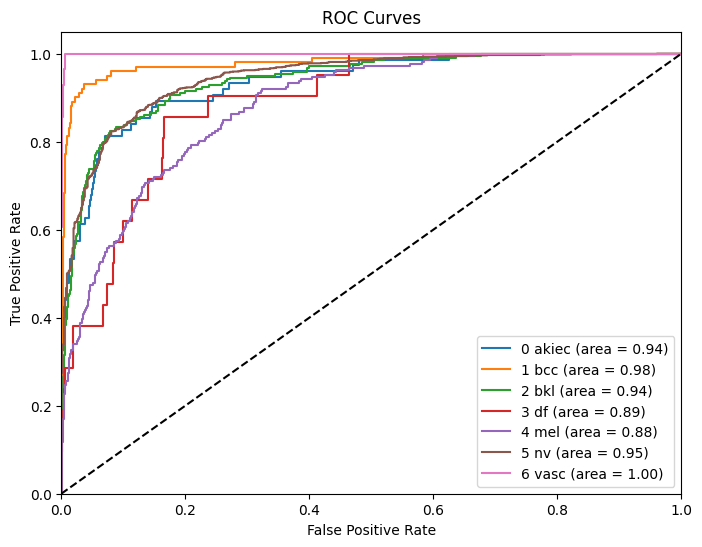

In [167]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [168]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [169]:
# 7 Class
metrics_hiba_7_3 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.603712   0.378049  0.280543  0.322078  0.742827
1      1           0.661977   0.704545  0.364706  0.480620  0.841826
2      2           0.570770   0.132450  0.227273  0.167364  0.708963
3      3           0.512213   0.133333  0.032787  0.052632  0.639323
4      4           0.613276   0.640000  0.252964  0.362606  0.753987
5      5           0.760715   0.570281  0.943522  0.710889  0.880675
6      6           0.556268   0.428571  0.117647  0.184615  0.759982

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.317063
1  Macro Avg Precision  0.426747
2     Macro Avg Recall  0.317063
3         Macro Avg F1  0.325829
4    Macro Avg Ovr AUC  0.761083


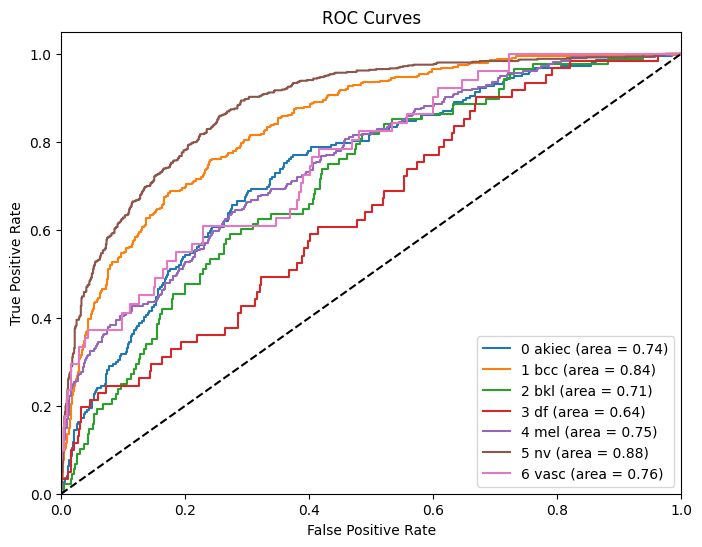

In [170]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [171]:
# Binary
grouped_on_skintype_7_3 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8556970595623962


In [172]:
grouped_on_skintype_7_3.overall

Balanced Acc    0.718287
Precision       0.904545
Recall          0.488943
F1              0.634769
FNR             0.511057
FPR             0.052369
dtype: float64

In [173]:
grouped_on_skintype_7_3.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.720682,0.971429,0.465753,0.629630,0.534247,0.024390
II,0.709124,0.908284,0.486529,0.633643,0.513471,0.068282
III,0.738152,0.864865,0.500000,0.633663,0.500000,0.023697
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.736528,0.833333,0.543478,0.657895,0.456522,0.070423


In [174]:
max_min_diff(grouped_on_skintype_7_3.by_group)

,Difference
Balanced Acc,0.029028
Precision,0.106564
Recall,0.034247
F1,0.004034
FNR,0.034247
FPR,0.044585


## Experiment 4-4

In [175]:
class_weights_4 = torch.FloatTensor([3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0])

### HAM10000 Test Set

In [176]:
model_path = 'Inception_Models_F1/inceptionv3_model_7_4.pth'
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HAM10000_dataloader)

In [177]:
metrics_7_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.752697   0.582090  0.520000  0.549296  0.958915
1      1           0.845404   0.755319  0.702970  0.728205  0.967443
2      2           0.803153   0.706468  0.639640  0.671395  0.942660
3      3           0.735558   0.500000  0.476190  0.487805  0.944046
4      4           0.785241   0.428144  0.677725  0.524771  0.896826
5      5           0.861490   0.925361  0.864318  0.893798  0.937272
6      6           0.963267   0.866667  0.928571  0.896552  0.987725

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.687059
1  Macro Avg Precision  0.680578
2     Macro Avg Recall  0.687059
3         Macro Avg F1  0.678832
4    Macro Avg Ovr AUC  0.947841


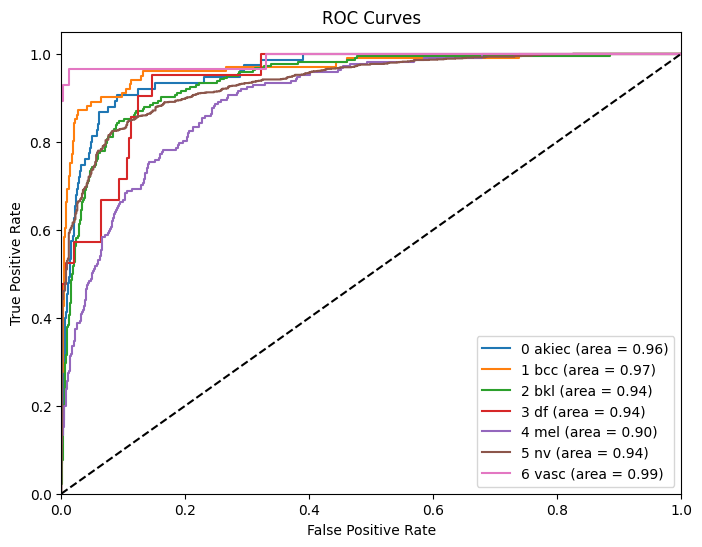

In [178]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

### HIBA Set

In [179]:
y_true, y_pred_prob, y_pred = get_test_predictions(model_path, HIBA_dataloader)

In [180]:
# 7 Class
metrics_hiba_7_4 = get_overall_metrics(y_true, y_pred_prob, y_pred)


Per Class Metrics:
   Class  Balanced Accuracy  Precision    Recall        F1       AUC
0      0           0.579207   0.369231  0.217195  0.273504  0.800915
1      1           0.596091   0.655172  0.223529  0.333333  0.813752
2      2           0.577225   0.130952  0.250000  0.171875  0.672314
3      3           0.563803   0.225000  0.147541  0.178218  0.632776
4      4           0.648069   0.500000  0.363636  0.421053  0.793489
5      5           0.765022   0.583949  0.918605  0.714009  0.892519
6      6           0.621700   0.419355  0.254902  0.317073  0.765959

Overall Metrics:
                Metric     Value
0    Balanced Accuracy  0.339344
1  Macro Avg Precision  0.411951
2     Macro Avg Recall  0.339344
3         Macro Avg F1  0.344152
4    Macro Avg Ovr AUC  0.767389


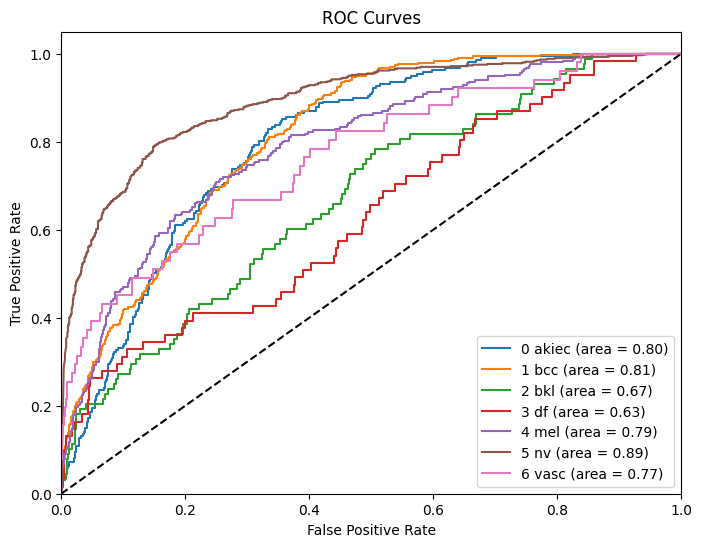

In [181]:
plot_AUC_ROC_curves(y_true, y_pred_prob, y_pred)

In [182]:
# Binary
grouped_on_skintype_7_4 = get_metric_frame(y_true, y_pred_prob, y_pred, 'skin_type')

AUC on HIBA Dataset: 0.8636287046511486


In [183]:
grouped_on_skintype_7_4.overall

Balanced Acc    0.692342
Precision       0.865116
Recall          0.457002
F1              0.598071
FNR             0.542998
FPR             0.072319
dtype: float64

In [184]:
grouped_on_skintype_7_4.by_group

,Balanced Acc,Precision,Recall,F1,FNR,FPR
skin_type,,,,,,
I,0.783829,0.957447,0.616438,0.750000,0.383562,0.048780
II,0.664078,0.854890,0.429477,0.571730,0.570523,0.101322
III,0.733412,0.820513,0.500000,0.621359,0.500000,0.033175
IV,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nan,0.739743,0.888889,0.521739,0.657534,0.478261,0.042254


In [185]:
max_min_diff(grouped_on_skintype_7_4.by_group)

,Difference
Balanced Acc,0.119751
Precision,0.136934
Recall,0.186961
F1,0.178270
FNR,0.186961
FPR,0.068146
